<h2> Introduction </h2>

In this kernel, we will use Gausian Process Regressions and Bayesian Optimisation on ecoacoustic metrics to quantify the spatiotemporal distribution of birds on-farm. The data was obtained by placing 20 audio recorders across the property in a grid formation. The biodiversity project was set up in 14 and 15th Nov 2019.


<h2> Our Goals </h2>

<ul>
<li> Understand the spatial and temporal variability in the data, in particular, study how avian species richness change, examine if there are seasonal cycles.
<li> Determine the optimal placement of the 20 audio recorders using the previously described methods. </li>
<li> Determine what the optimal placement would be if one or more of the recorders were to stop functioning. </li>
</ul>


<h2> Outline </h2>

I. <b>Our Toolbox</b><br>
a) [The PreProcessing Class](#preprocessingclass)<br>
b) [The EcouacousticModel Class](#ecoacousticmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The SingleFrameGaussianProcessModel Class](#singlegpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The FullGaussianProcessModel Class](#fullgpclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The TSModel Class](#tsmodelclass)<br>
c) [The EcouacousticAnalysis Class](#ecoacousticanalysisclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(i) [The Visualise Class](#visualiseclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(ii) [The SVDModel Class](#svdmodelclass)<br>
&nbsp;&nbsp;&nbsp;&nbsp;(iii) [The SiteSelection Class](#siteselectionclass)<br>


II. <b>Understanding our data</b><br>
b) [Initializing and pre-processing our data](#initializing)<br>
b) [Gathering sense of our data](#gather)<br>


III. <b>Gaussian Process Regression spatiotemporal predictions</b><br>
a) [Picture: single timeframe spatial gaussian process regression predictions](#singlegp)<br>
b) [Video: spatiotemporal gaussian process regression predictions over the whole timeframe](#fullgp)<br>
b) [Optimising the selection of subsequent sites](#optimisingsites)<br>



IV. <b>Understanding the spatial and temporal variability in avian richness</b><br>
a) [Timeseries analysis](#tsmodel)<br>
b) [Spatiotemporal analysis?](#spatiotemporal)<br>

In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import statsmodels.api as sm
from itertools import product
import datetime as dt
from os.path import exists

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from shapely.geometry import Point, shape, Polygon
import geojson
import utm

import warnings
# warnings.filterwarnings("ignore")

<h2> I. Our Toolbox </h2>
<a id="preprocessingclass"></a>

<h3>a) The PreProcessing Class</h3>

-Explanation here-

In [2]:
from preprocessing.preprocessing import PreProcessing

<a id="ecoacousticmodelclass"></a>

<h3>b) The EcoacousticModel class</h3>

-Explanation here-

In [3]:
from models.ecoacoustic_model import EcoacousticModel

<a id="singlegpclass"></a>

<h4>b) (i) The SingleFrameGaussianProcessModel class</h4>

-Explanation here-

In [4]:
from models.single_frame_gaussian_process_model import SingleFrameGaussianProcessModel

<a id="fullgpclass"></a>

<h4>b) (ii) The FullGaussianProcessModel class</h4>

-Explanation here-

In [5]:
from models.full_gaussian_process_model import FullGaussianProcessModel

<a id="tsmodelclass"></a>

<h4>b) (iii) The TSModel class</h4>

-Explanation here-

In [6]:
from models.ts_model import TSModel

<a id="ecoacousticanalysisclass"></a>

<h3>c) The EcoacousticAnalysis class</h3>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [7]:
from analysis.ecoacoustic_analysis import EcoacousticAnalysis

<a id="visualiseclass"></a>

<h4>c) (i) The Visualise class</h4>

-Explanation here-

In [8]:
from analysis.visualise import Visualise

<a id="svdmodelclass"></a>

<h4>c) (ii) The SVDModel class</h4>

-Explanation here-

Will be used to visualise modes of the full Gaussian process

In [9]:
from analysis.svd_analysis import SVDAnalysis

<a id="siteselectionclass"></a>

<h4>c) (iii) The SiteSelection class</h4>

-Explanation here-

In [10]:
from analysis.site_selection import SiteSelection

<h2> II. Understanding our data </h2>

<a id="initializing"></a>

<h3>a) Initializing and pre-processing our data</h3>

-Explanation here

In [11]:
preprocessor = PreProcessing('../data/instrument_data.csv','../data/instrument_metadata.csv','ADI')
preprocessor.remove_plot()
metadata = preprocessor.get_metadata()
ecoacoustic_data = preprocessor.get_current_cleaned_data()
ecoacoustic_date_data = preprocessor.get_current_cleaned_date_data(ecoacoustic_data)
period = preprocessor.get_av_period(ecoacoustic_data)

C:\Users\23478671\Dropbox\Final Project\data\digifarm-ecoacoustics\Final_Project\code\preprocessing\preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[name] = data[name].interpolate()
C:\Users\23478671\Dropbox\Final Project\data\digifarm-ecoacoustics\Final_Project\code\preprocessing\preprocessing.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['time'] = self.all_times[ranges[max_range_idx][0]:ranges[max_range_idx][1]]


<a id="gathering"></a>

<h3>b) Gathering sense of our data</h3>

-Explanation here-

In [12]:
# visualiser = Visualise()
# site = 'A02'
# single_site_data = preprocessor.get_single_site_data(ecoacoustic_data, site)
# visualiser.plot_all_ts(single_site_data,site,'test')
# visualiser.point_animation(ecoacoustic_data,metadata,'test')

<h2> III. Gaussian Process Regression spatiotemporal predictions </h2>

<a id="singlegp"></a>

<h3>a) Picture: single timeframe spatial gaussian process regression predictions</h3>

-Explanation here-


Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


This file already exists


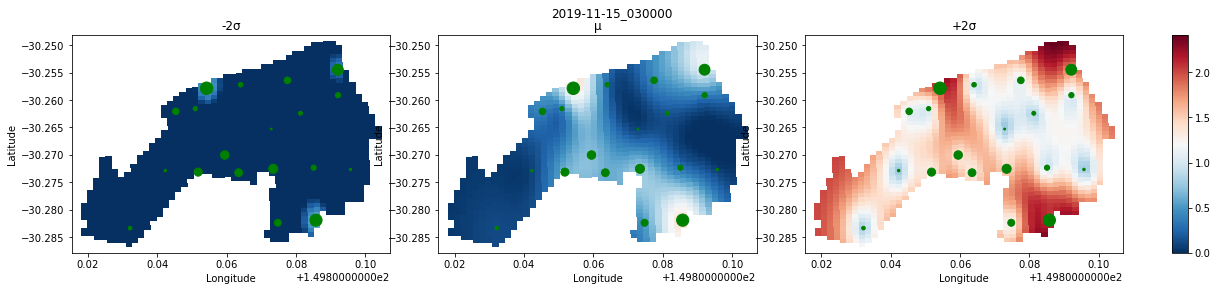

Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


This file already exists


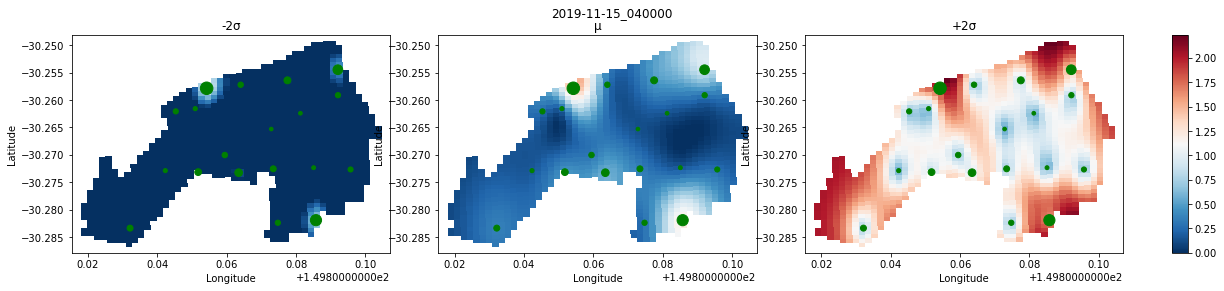

Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


This file already exists


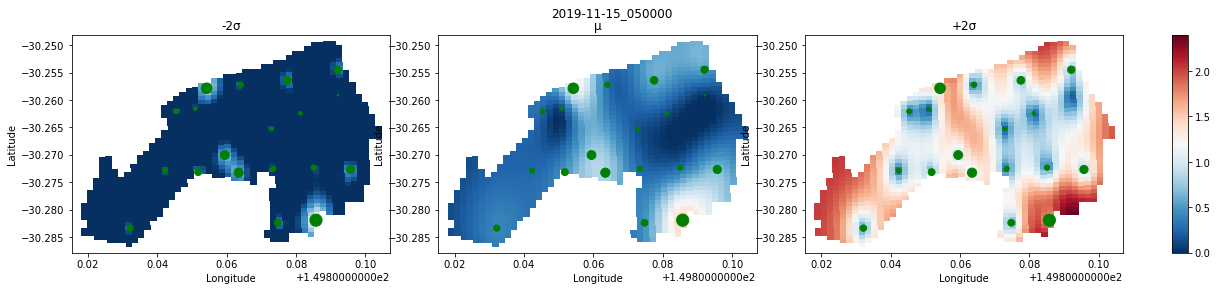

Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


This file already exists


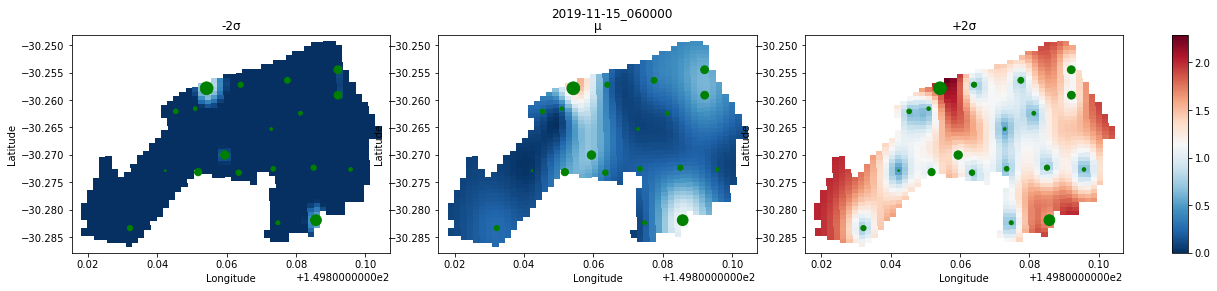

Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


This file already exists


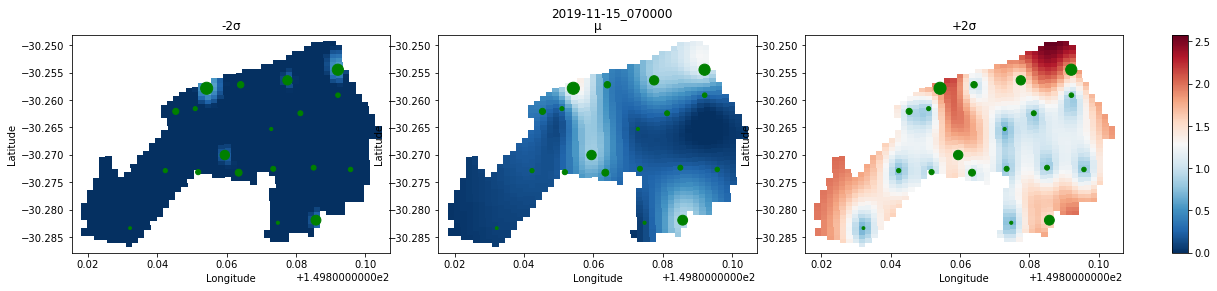

In [13]:
resolution = 50
for i in range(5):
    single_frame_data = preprocessor.get_single_frame_data(ecoacoustic_data,i)
    X_train = single_frame_data[['long','lat']].values
    y_train = single_frame_data.val.values
    
    single_frame_gp_model = SingleFrameGaussianProcessModel(title = ecoacoustic_data.index[i])
    single_frame_gp_model.train(X_train,y_train)
    
    # Predict
    soa_shape_map_path = '../data/GIS/Boundaries/Farm_boundary_new.geojson'

    with open(soa_shape_map_path) as f:
        gj = geojson.load(f)
    features = gj['features'][0]

    # determine maximum edges
    polygon = shape(features['geometry'])
    latmin, lonmin, latmax, lonmax = polygon.bounds

    # construct a rectangular mesh
    points = []
    latlons_all = []
    lats = np.linspace(latmin, latmax, resolution)
    lons = np.linspace(lonmin, lonmax, resolution)

    for lat in lats:
        for lon in lons:
            points.append(Point((round(lat,4), round(lon,4))))

    for point in points:
        latlons_all.append(list(utm.to_latlon(point.x, point.y, 55, northern=False)))

    valid_points=[]
    # validate if each point falls inside shape
    valid_points.extend([i for i in points if polygon.contains(i)])

    # Obtain spatial component of input array
    listlatlon = []
    for point in valid_points:
        listlatlon.append(list(utm.to_latlon(point.x, point.y, 55, northern=False)))
    x1x2 = np.array(listlatlon)
    x1x2 = np.array([x1x2[:,1],x1x2[:,0]]).T

    
    y_pred,y_lower,y_higher = single_frame_gp_model.predict(x1x2,latlons_all,plot=True)

<a id="fullgp"></a>

<h3>b) Video: spatiotemporal gaussian process regression predictions over the whole timeframe</h3>

-Explanation here-

Initializing Model


C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\23478671\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

This file already exists
This file already exists


C:\Users\23478671\Anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


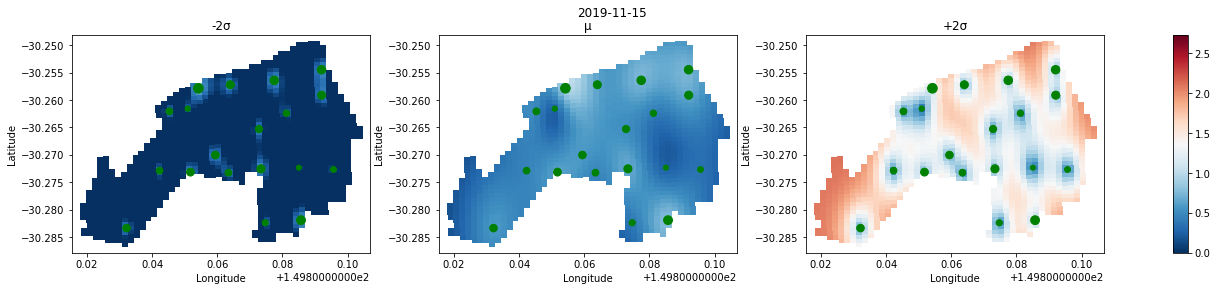

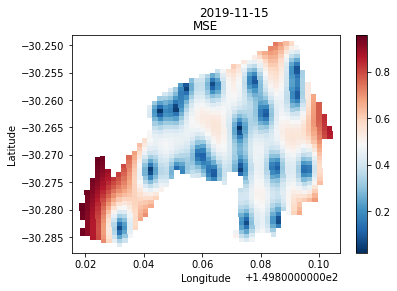

In [14]:
# Prepare data for Full GP
data_for_gp = preprocessor.get_data_for_full_gp(ecoacoustic_date_data,av_each_date = True)

# Initialize model
full_gp_model = FullGaussianProcessModel()

# Train model
X = data_for_gp[['long','lat','time']].values
y = data_for_gp.val.values
full_gp_model.train(X,y)

# Predict
resolution = 50

soa_shape_map_path = '../data/GIS/Boundaries/Farm_boundary_new.geojson'

with open(soa_shape_map_path) as f:
    gj = geojson.load(f)
features = gj['features'][0]

# determine maximum edges
polygon = shape(features['geometry'])
latmin, lonmin, latmax, lonmax = polygon.bounds

# construct a rectangular mesh
points = []
latlons_all = []
lats = np.linspace(latmin, latmax, resolution)
lons = np.linspace(lonmin, lonmax, resolution)

for lat in lats:
    for lon in lons:
        points.append(Point((round(lat,4), round(lon,4))))

for point in points:
    latlons_all.append(list(utm.to_latlon(point.x, point.y, 55, northern=False)))

valid_points=[]
# validate if each point falls inside shape
valid_points.extend([i for i in points if polygon.contains(i)])

# Obtain spatial component of input array
listlatlon = []
for point in valid_points:
    listlatlon.append(list(utm.to_latlon(point.x, point.y, 55, northern=False)))
x1x2 = np.array(listlatlon)

# Combining with temporal component
x3 = np.linspace(np.min(data_for_gp.time), np.max(data_for_gp.time),data_for_gp.time.unique().size)
x1x2x3 = np.array(list(product(x1x2, x3)))
x1x2x3_new = []
for item in x1x2x3:
    x1x2x3_new.append([item[0][1],item[0][0],item[1]])

# Predicting
y_pred,y_lower,y_higher,MSE = full_gp_model.predict(np.array(x1x2x3_new),np.array(latlons_all),plot = True)

In [37]:
y_pred.to_pickle('../results/GPs/full_gp/y_pred.pkl')
y_lower.to_pickle('../results/GPs/full_gp/y_lower.pkl')
y_higher.to_pickle('../results/GPs/full_gp/y_higher.pkl')
MSE.to_pickle('../results/GPs/full_gp/MSE.pkl')

In [41]:
f = open('../results/GPs/full_gp/y_higher.pkl', 'rb')
yhigher = pickle.load(f)   
yhigher

,,1.573736e+09,1.573823e+09,1.573909e+09,1.573996e+09,1.574082e+09,1.574168e+09,1.574255e+09,1.574341e+09,1.574428e+09,1.574514e+09,...,1.576588e+09,1.576674e+09,1.576760e+09,1.576847e+09,1.576933e+09,1.577020e+09,1.577106e+09,1.577192e+09,1.577279e+09,1.577365e+09
longs,lats,,,,,,,,,,,,,,,,,,,,,
149.817289,-30.287513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817267,-30.286757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817245,-30.286002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817224,-30.285246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817202,-30.284491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149.905110,-30.251573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.905088,-30.250817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.905066,-30.250062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
import pickle
f = open('../results/GPs/full_gp/y_pred.pkl', 'rb')
ypred = pickle.load(f)   


,,1.573736e+09,1.573823e+09,1.573909e+09,1.573996e+09,1.574082e+09,1.574168e+09,1.574255e+09,1.574341e+09,1.574428e+09,1.574514e+09,...,1.576588e+09,1.576674e+09,1.576760e+09,1.576847e+09,1.576933e+09,1.577020e+09,1.577106e+09,1.577192e+09,1.577279e+09,1.577365e+09
longs,lats,,,,,,,,,,,,,,,,,,,,,
149.817289,-30.287513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817267,-30.286757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817245,-30.286002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817224,-30.285246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.817202,-30.284491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149.905110,-30.251573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.905088,-30.250817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149.905066,-30.250062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
pd.read_csv('../results/GPs/full_gp/y_pred.csv').encode('utf-8').strip()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

<a id="optimisingsites"></a>

<h3>c) Optimising the selection of the next site</h3>

-Explanation here-

Analyzing!
This file already exists


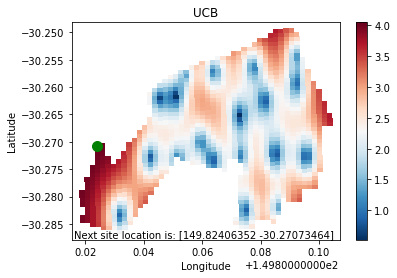

In [15]:
num_sites = np.unique(X[:,0]).size

site_selection = SiteSelection(y_pred,MSE,'UCB',num_sites)

<h2> IV. Understanding the spatial and temporal variability in avian richness </h2>
<a id="tsmodel"></a>

<h3>a) Timeseries analysis </h3>

-Explanation here-

In [16]:
# site = 'A02'
# single_site_data = preprocessor.get_single_site_data(ecoacoustic_data, site)

# ts_model = TSModel(single_site_data, period=24)
# decomposition = ts_model.seasonal_decompose()

# data = ts_model.get_one_period_ahead_pred()

<a id="spatiotemporal"></a>

<h3>a) Spatiotemporal analysis </h3>

-Explanation here-

Analyzing!
This file already exists


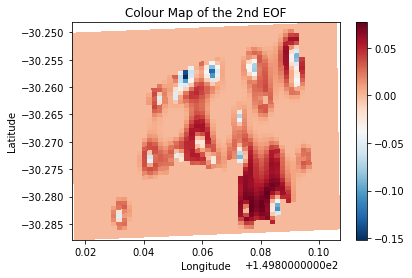

In [17]:
svd_model = SVDAnalysis(y_lower.fillna(0),data_for_gp.long.unique().size,'lower')
svd_model.show_EOF(resolution,2)
# svd_model.show_variance_weights()
